# Create raw Data

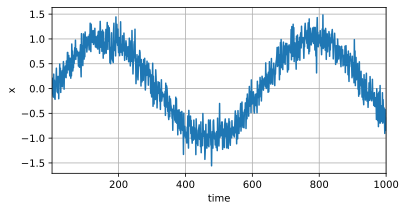

In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

# 总时间步数
T = 1000 
# 创建一个从1到T的张量
time = torch.arange(1, T + 1, dtype=torch.float32) # 1到1000为时间
# 生成频率为0.01的正弦波并加入随机噪声
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
# 绘制数据
d2l.plot(time, x, 'time', 'x', xlim=[1,1000], figsize=(6,3))

In [2]:
x.shape
# X in R
# sample 1000 X

torch.Size([1000])

# Map Data to Seq Data

In [3]:
# 延迟时间步长
tau = 4
# 创建一个形状为(T - tau, tau)的零张量作为特征
features = torch.zeros((T - tau, tau)) # T - tau + 1 为样本数，tau 为特征数
# 每四个数据作为特征，第五个作为标签，不断构造这样的数据形成数据集
for i in range(tau):
    # 每四个数据作为特征，第五个作为标签，不断构造这样的数据形成数据集
    features[:, i] = x[i:T - tau + i]
# 所从第5个时刻开始，每个时刻的label是该时刻的x值，该时刻的输入是前4个时刻的数值组成的一个向量。
# 经过变化后数据的输入共有996组4个一组的数据，输出共996个值
# 提取标签数据并进行形状变换
labels = x[tau:].reshape((-1, 1))
# 批量大小和训练样本数量
batch_size, n_train = 16, 600
# 使用 features 和 labels 的前 n_train 个样本创建一个可迭代的训练集
train_iter = d2l.load_array(
    (features[:n_train], labels[:n_train]),
    batch_size, 
    is_train=True
    )

In [4]:
x[tau:].shape, labels.shape

(torch.Size([996]), torch.Size([996, 1]))

In [5]:
features[-2:], x[-1], labels[-1]

(tensor([[-0.5830, -0.9045, -0.4223, -0.8463],
         [-0.9045, -0.4223, -0.8463, -0.6808]]),
 tensor(-0.5934),
 tensor([-0.5934]))

### Seq Data
S $\in$ $\mathbb{R}^4$, y $\in$ $\mathbb{R}$ 

Suppose we have 1000 data, how to sample ~1000 (S, y):

for S:
1. if tau = 4, make sure that we have 996 (S, y)
2. we initial 996 * 4 matrix
3. for each row (4) in 996 * 4, input 4 rolling window in 1000 data 
4. note that here, we dont use the entire 997 data, we leave 1 for labels

for y:
1. we use the 1000 data starting from fifth data (in cs, index is 4)

# Create Net and Define Loss

In [6]:
def get_net():

    def init_weights(m):
        # 如果当前模块是线性层
        if type(m) == nn.Linear:
            # 初始化权重函数 
            nn.init.xavier_uniform_(m.weight)
    
    # 定义神经网络结构
    # sequential 把net和forward函数都包在一块了啊
    net = nn.Sequential(
        nn.Linear(4, 10), 
        nn.ReLU(), 
        nn.Linear(10, 1)
        )
    
    # 对网络的权重进行初始化
    net.apply(init_weights)
    # 返回构建好的神经网络模型
    return net

# Train Process

In [7]:
def train(net, train_iter, epochs, lr):

    # 定义均方误差损失函数
    loss = nn.MSELoss()
    # 定义优化器
    trainer = torch.optim.Adam(net.parameters(), lr)

    # 迭代训练指定的轮数
    for epoch in range(epochs):
        # 遍历训练集中的每个批次
        for X, y in train_iter:
            # 梯度清零
            trainer.zero_grad()
            # 前向传播计算损失
            y_hat = net(X)
            # loss
            l = loss(y_hat, y)
            # 反向传播求梯度 藏在W, b上的梯度 这个.backward有点像远程遥控器的感觉
            l.backward()
            # 更新模型参数
            trainer.step()
        # 打印当前轮次的损失
        print(f'epoch {epoch + 1}, '
             f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

In [8]:
# 创建神经网络模型
net = get_net() # 居然不用torch的框架...
# 训练模型
train(net, train_iter, 10, 0.01)

epoch 1, loss: 0.055640
epoch 2, loss: 0.054687
epoch 3, loss: 0.053207
epoch 4, loss: 0.055447
epoch 5, loss: 0.050892
epoch 6, loss: 0.053668
epoch 7, loss: 0.051033
epoch 8, loss: 0.050829
epoch 9, loss: 0.054531
epoch 10, loss: 0.051533


# Model Evaluation
肉眼观察法

In [9]:
features.shape

torch.Size([996, 4])

In [10]:
# import torch

# # 创建一个张量并设置 requires_grad=True
# x = torch.tensor([1.0, 2.0, 3.0], requires_grad=True)
# print(x.grad)

# x.sum().backward()
# print(x.grad)

# x.grad.zero_()

# # 进行一些计算
# y = x * 2
# print(y.requires_grad)
# print(x.grad)

# z = y.sum()
# print(x.grad)

# # 计算梯度
# z.backward()
# print(x.grad)  # 输出：tensor([2., 2., 2.])

# # 使用 detach() 分离张量
# y_detached = y.detach()
# print(x.grad)
# print(y_detached.requires_grad)

# # 进行进一步计算，但不再跟踪梯度
# z_detached = y_detached.sum()
# # z_detached.backward()  # 不会影响 x 的梯度

# print(x.grad)  # 仍然输出：tensor([2., 2., 2.])


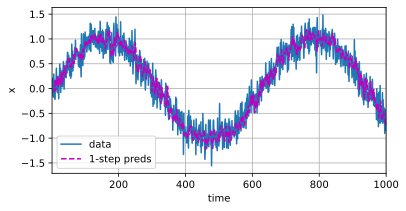

In [11]:
# 对特征进行一步预测
onestep_preds = net(features)
# 进行数据可视化，将真实数据和一步预测结果绘制在同一个图中进行比较
d2l.plot(
    [time, time[tau:]], 
    [x.detach().numpy(), onestep_preds.detach().numpy()], 
    'time', 
    'x', 
    legend = ['data','1-step preds'], 
    xlim = [1, 1000], 
    figsize=(6,3) 
    )   

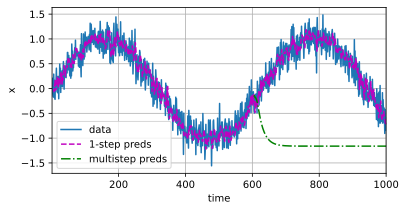

In [12]:
# 初始化多步预测结果的张量
multistep_preds = torch.zeros(T)
# 将已知的真实数据赋值给多步预测结果
multistep_preds[:n_train + tau] = x[:n_train + tau]
# 对剩余时间步进行多步预测
for i in range(n_train + tau, T):
    # 获得多步预测结果
    multistep_preds[i] = net(multistep_preds[i - tau:i].reshape((1,-1)))

# 进行数据可视化
d2l.plot(
    [
        time, 
        time[tau:], 
        time[n_train + tau:] 
        ], 
    [
        x.detach().numpy(), 
        onestep_preds.detach().numpy(), 
        multistep_preds[n_train + tau:].detach().numpy()
        ],        
    'time', 
    'x', 
    legend = [
        'data', 
        '1-step preds', 
        'multistep preds'
        ], 
    xlim=[1, 1000],
    figsize=(6, 3) )  

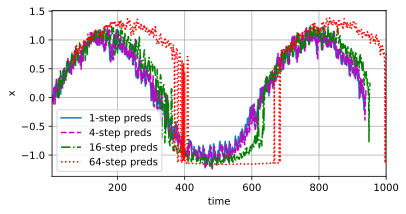

In [13]:
# 最大步长
max_steps = 64
# 初始化特征张量
features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# 从 0 到 tau-1进行遍历
for i in range(tau):
    # 构造特征矩阵
    features[:, i] = x[i:i + T - tau - max_steps + 1]
    
# 从 tau 到 tau + max_steps - 1，通过 net(features[:, i - tau:i]) 进行多步预测
for i in range(tau, tau + max_steps):
    # 进行多步预测并更新特征矩阵
    features[:,i] = net(features[:, i - tau:i]).reshape(-1)
    
# 预测的步长
steps = (1, 4, 16, 64)
# 进行数据可视化
d2l.plot([time[tau + i - 1:T - max_steps + i] for i in steps],
        [features[:, (tau + i - 1)].detach().numpy() for i in steps],
        'time',
        'x',
        legend = [f'{i}-step preds' for i in steps],
        xlim = [5,1000],
        figsize=(6,3) 
        )